# PixelFrame engineering design demo

To do

Shear from steel fiber.
actual length for absolute value of tendon profile
servicability from the model

Import required packages

In [1]:
using Pkg
Pkg.activate("..");
Pkg.status()
Pkg.instantiate()

  Activating project at `~/dev/ConcreteExplorer`


Status `~/dev/ConcreteExplorer/Project.toml`
  [acfe5cae] AsapSections v0.1.0 `https://github.com/keithjlee/AsapSections#main`
  [336ed68f] CSV v0.10.12
  [13f3f980] CairoMakie v0.11.5
  [a93c6f00] DataFrames v1.6.1
  [59287772] Formatting v0.4.2
  [f6369f11] ForwardDiff v0.10.36
  [e9467ef8] GLMakie v0.9.5
  [682c06a0] JSON v0.21.4
  [ee78f7c6] Makie v0.20.4
  [01bcebdf] Nonconvex v2.1.3
  [d3d89cbb] NonconvexMMA v1.0.0
  [b43a31b8] NonconvexNLopt v0.1.8
  [429524aa] Optim v1.7.8
⌃ [7f7a1694] Optimization v3.20.2
⌃ [4e6fcdb7] OptimizationNLopt v0.1.8
  [49802e3a] ProgressBars v1.5.1
  [90137ffa] StaticArrays v1.9.1
  [e88e6eb3] Zygote v0.6.68
  [10745b16] Statistics v1.9.0
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [2]:
using CSV
using DataFrames
using JSON
using Dates
using ProgressBars

Load the precalculated catalog

In [3]:
pwd()

"/Users/pitipatwongsittikan/dev/ConcreteExplorer/src"

In [4]:
catalog = CSV.read("Catalogs/test_catalog.csv", DataFrame); #load the pre-calc catalog
sort!(catalog, [:carbon, :fc′, :as, :ec])


println("The catalog was sorted by ascending order from:\ncarbon -> fc′ -> as -> ec")
println(catalog[1:20,:])

The catalog was sorted by ascending order from:
carbon -> fc′ -> as -> ec


20×9 DataFrame
 Row │ fc′      as       ec       fpe      Pu       Mu       Vu       carbon   ID    
     │ Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Int64 
─────┼───────────────────────────────────────────────────────────────────────────────
   1 │    28.0     99.0     0.05      0.0  627.772  109.659  8.14936  16.6541      1
   2 │    28.0     99.0     0.05     46.5  625.378  108.641  8.14928  16.6541      2
   3 │    28.0     99.0     0.05     93.0  622.985  107.706  8.1492   16.6541      3
   4 │    28.0     99.0     0.05    139.5  620.591  106.846  8.14912  16.6541      4
   5 │    28.0     99.0     0.05    186.0  618.197  106.032  8.14904  16.6541      5
   6 │    28.0     99.0     0.05    232.5  615.803  108.382  8.14896  16.6541      6
   7 │    28.0     99.0     0.05    279.0  613.409  110.748  8.14887  16.6541      7
   8 │    28.0     99.0     0.05    325.5  611.016  113.116  8.14879  16.6541      8
   9 │    28.0     99.0     0.05    372.0  608.

Load the demand file   

In [5]:
#load demands into a dictionary
demand_path = joinpath(@__DIR__, "Demands/test_input_CISBAT_dataset.json");
open(demand_path, "r") do f
    global demands = DataFrame(JSON.parse(f, dicttype=Dict{String,Any}))
    ns = size(demands)[1]
    demands[!,:idx] = 1:ns
    println("Demands were loads from:\n", demand_path)
end
println(demands[1:10,:])

Demands were loads from:
/Users/pitipatwongsittikan/dev/ConcreteExplorer/src/Demands/test_input_CISBAT_dataset.json
10×8 DataFrame
 Row │ vu        s_idx  pu            e_idx  type     ec_max     mu       idx   
     │ Float64   Int64  Float64       Int64  String   Float64    Float64  Int64 
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 129.755       0  -1.4779e-15       0  primary  0.0423597  129.755      1
   2 │ 129.755       1  -7.38948e-16      0  primary  0.117666   194.632      2
   3 │ 129.755       2  -7.38948e-16      0  primary  0.180421   259.509      3
   4 │  45.9809      3   1.4779e-15       0  primary  0.230625   283.246      4
   5 │  45.9809      4   7.38948e-16      0  primary  0.268278   306.237      5
   6 │  45.9809      5  -7.38948e-16      0  primary  0.29338    329.227      6
   7 │  45.9809      6  -7.38948e-16      0  primary  0.305931   352.218      7
   8 │  45.9809      7   0.0              0  primary  0.305931   3

The demand catalog was labeled with 0 index scheme, add 1 so they are compatible with Julia 1 index scheme.

In [6]:
@show old_min_e_idx = minimum(demands[!, "e_idx"]);
@show old_min_s_idx = minimum(demands[!, "s_idx"]);

@show old_max_e_idx = maximum(demands[!, "e_idx"]);
@show old_max_s_idx = maximum(demands[!, "s_idx"]);



old_min_e_idx = minimum(demands[!, "e_idx"]) = 0
old_min_s_idx = minimum(demands[!, "s_idx"]) = 0
old_max_e_idx = maximum(demands[!, "e_idx"]) = 29
old_max_s_idx = maximum(demands[!, "s_idx"]) = 13


In [7]:
demands[!,"e_idx"] .+= 1 ;
demands[!,"s_idx"] .+= 1 ;

In [8]:
@show new_min_e_idx = minimum(demands[!, "e_idx"]);
@show new_min_s_idx = minimum(demands[!, "s_idx"]);

@show new_max_e_idx = maximum(demands[!, "e_idx"]);
@show new_max_s_idx = maximum(demands[!, "s_idx"]);


new_min_e_idx = minimum(demands[!, "e_idx"]) = 1
new_min_s_idx = minimum(demands[!, "s_idx"]) = 1
new_max_e_idx = maximum(demands[!, "e_idx"]) = 30
new_max_s_idx = maximum(demands[!, "s_idx"]) = 14


Fix redundant element indices due to Primary and Secondary labels

In [9]:
global e_idx = 1 
for i in 1:size(demands)[1]
    if i !=1
        demands[i-1, :e_idx] = e_idx
        if demands[i,:s_idx] < demands[i-1,:s_idx]
            global e_idx +=1 
        end
        
    end
    if i == size(demands)[1]
        demands[i, :e_idx] = e_idx
    end
end

Create a function to filter only feasible designs in a demand point

In [10]:

"""
filter feasible demands
"""
function filter_demands(demands::DataFrame, catalog::DataFrame)

    ns = size(demands)[1]          #total number of sections
    ne = unique(demands[!, :e_idx]) #total number of elements
    nc = size(catalog, 1)           #total number of available choices

    output_results = Dict{Int64,Vector{Int64}}() #map between demands and indices of the feasible section.
    demands[!, "total_results"] = zeros(Int64, size(demands)[1])
    #go through each section and filter the feasible designs from the catalog.
    for i = 1:ns
        en = demands[i, "e_idx"]
        sn = demands[i, "s_idx"]
        # push!(elements_to_sections[en], sn)

        pu = demands[i, "pu"]
        mu = demands[i, "mu"]
        # vu = demands[i,"vu"]
        ec_max = demands[i, "ec_max"]

        global feasible_sections = filter([:Pu, :Mu, :Vu, :ec] => (x1, x2, x3, x4) ->
                x1 > pu &&
                x2 > mu &&
                # x3 > vu && Have not consider the shear
                x4 <= ec_max * 1000,
            catalog
        )

        if size(feasible_sections)[1] == 0 #if the number of feasible results = 0
            println(feasible_sections[!, :ID])
            println("section $sn: element $en")
            output_results[i] = [0]
            demands[i, "total_results"] = 0
            # println(outr)
        else
            output_results[i] = feasible_sections[!, :ID]
            demands[i, "total_results"] = length(feasible_sections[!, :ID])
            # println(outr)
        end
    end

    return output_results
end


filter_demands

In [20]:
"""
Find the optimum result for each element.
    
    !! not optimum
For the same element, will use the same fc′ steel size and post tensioning stress.

"""
function find_optimum(output_results, demands)
    total_ns = size(demands)[1] #get total number of section points.
    ne = unique(demands[!, :e_idx]) #number of elements

    #Map element indices to indices of sections indices on those elements.
    elements_to_sections = Dict(k => Int[] for k in unique(demands[!, "e_idx"]))
    for i = 1:total_ns
        en = demands[i, "e_idx"]
        # sn = demands[i, "s_idx"]
        push!(elements_to_sections[en], i)
    end


    #element index to list of designs
    elements_designs = Dict(k => [[]] for k in unique(demands[!, "e_idx"])) 


    #find fc′, as, and fpe that appear in all sections in an element.
    for i in ProgressBar(ne) #loop each element
        println("Element $i out of $(length(ne)) elements")
        sections = elements_to_sections[i] #sections associated with this element

        ns = length(sections)     # number of sections in this element 

        #start from the middle-ish section (n/2 or (n-1)/2)
        #note that section is in the form of 1,2,3,..., ns.

        mid = div(ns, 2)
        
        #get the feasible designs for the middle section
        feasible_idx = output_results[sections[mid]]

        #catalog was already sorted, so I think we can leave this part, just filter, to save time.
        mid_catalog = sort(catalog[feasible_idx, :], [:carbon, :fc′, :ec])
        # mid_catalog = catalog[feasible_idx, :]

        #now, loop each design in the sub catalog, see if as and fpe are available in all sections.
        #if not, remove that design from the sub catalog.
        #if yes, keep it.

        #select each design, check if as and fpe exist for the the section
        global_d = 0
        for d_idx in 1:size(catalog)[1]
            d = mid_catalog[d_idx, :]

            all_as = true
            all_fpe = true
            for s in sections
                #check if the design is available in that section.
                #if not, remove it from the sub catalog.
                #if yes, keep it.
                # if !(d[:fc′] ∈ catalog[output_results[s], :fc′])
                #     all_fc′ = false
                # end
                if !(d[:as] ∈ catalog[output_results[s], :as])
                    all_as = false
                    break
                end
                if !(d[:fpe] ∈ catalog[output_results[s], :fpe])
                    all_fpe = false
                    break
                end
            end
            if all_as && all_fpe
                #first run, found, move on.
                global_d = d_idx
                break
            end
        end

        #get the first one, they will appear in the entire thing anyway.
        this_fpe = mid_catalog[global_d, :fpe]
        this_as = mid_catalog[global_d, :as]

        sections_designs = Vector{Vector}(undef, ns)
        for is in eachindex(elements_to_sections[i])
            #current section index
            s = elements_to_sections[i][is]

            feasible_idx = output_results[s]
            
            fpe_as(fpe::Float64, as::Float64) = fpe == this_fpe && as == this_as

            this_catalog = filter([:fpe, :as] => fpe_as, catalog[output_results[s], :])

            sort!(this_catalog, [:carbon, :ec])

            #get the first one, it's the lowest carbon
            select_ID = this_catalog[1, :ID]
            #find lowest e for this one.
            sections_designs[is] = collect(catalog[select_ID, :])
            # println(sections_designs[is])
        end

        elements_designs[i] = sections_designs

    end

    return elements_designs, elements_to_sections
end

find_optimum

In [24]:
output_results= filter_demands(demands,catalog)


Dict{Int64, Vector{Int64}} with 552 entries:
  56  => [16, 17, 18, 19, 20, 21, 22, 23, 24, 25  …  21799, 21800, 21801, 21802…
  35  => [975, 976, 977, 978, 979, 1003, 1004, 1005, 1006, 1007  …  21799, 2180…
  425 => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  21799, 21800, 21801, 21802, 21803, …
  429 => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  21799, 21800, 21801, 21802, 21803, …
  60  => [6658, 6659, 6660, 6661, 6686, 6687, 6688, 6689, 6690, 6691  …  21799,…
  220 => [134, 135, 136, 160, 161, 162, 163, 164, 165, 166  …  21799, 21800, 21…
  308 => [45, 46, 47, 48, 49, 50, 51, 52, 53, 54  …  21799, 21800, 21801, 21802…
  67  => [6658, 6659, 6660, 6661, 6686, 6687, 6688, 6689, 6690, 6691  …  21799,…
  215 => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  21799, 21800, 21801, 21802, 21803, …
  73  => [569, 570, 571, 572, 573, 596, 597, 598, 599, 600  …  21799, 21800, 21…
  319 => [45, 46, 47, 48, 49, 50, 51, 52, 53, 54  …  21799, 21800, 21801, 21802…
  251 => [132, 133, 134, 135, 136, 137, 138, 139, 140, 141  …  2

In [25]:
elements_designs, elements_to_sections  = find_optimum(output_results, demands)


Element 1 out of 57 elements


0.0%┣                                               ┫ 0/57 [00:00<00:00, -0s/it]


Element 2 out of 57 elements
Element 3 out of 57 elements
Element 4 out of 57 elements
Element 5 out of 57 elements
Element 6 out of 57 elements
Element 7 out of 57 elements
Element 8 out of 57 elements
Element 9 out of 57 elements
Element 10 out of 57 elements
Element 11 out of 57 elements
Element 12 out of 57 elements
Element 13 out of 57 elements
Element 14 out of 57 elements
Element 15 out of 57 elements
Element 16 out of 57 elements
Element 17 out of 57 elements
Element 18 out of 57 elements
Element 19 out of 57 elements
Element 20 out of 57 elements
Element 21 out of 57 elements
Element 22 out of 57 elements
Element 23 out of 57 elements


1.8%┣▊                                          ┫ 1/57 [00:00<Inf:Inf, InfGs/it]
19.3%┣████████▊                                    ┫ 11/57 [00:00<00:01, 65it/s]


Element 24 out of 57 elements
Element 25 out of 57 elements
Element 26 out of 57 elements
Element 27 out of 57 elements
Element 28 out of 57 elements
Element 29 out of 57 elements
Element 30 out of 57 elements
Element 31 out of 57 elements
Element 32 out of 57 elements
Element 33 out of 57 elements
Element 34 out of 57 elements
Element 35 out of 57 elements
Element 36 out of 57 elements
Element 37 out of 57 elements
Element 38 out of 57 elements
Element 39 out of 57 elements
Element 40 out of 57 elements
Element 41 out of 57 elements
Element 42 out of 57 elements
Element 43 out of 57 elements
Element 44 out of 57 elements
Element 45 out of 57 elements
Element 46 out of 57 elements
Element 47 out of 57 elements
Element 48 out of 57 elements
Element 49 out of 57 elements
Element 50 out of 57 elements
Element 51 out of 57 elements
Element 52 out of 57 elements
Element 53 out of 57 elements
Element 54 out of 57 elements
Element 55 out of 57 elements
Element 56 out of 57 elements
Element 57

42.1%┣██████████████████▌                         ┫ 24/57 [00:00<00:00, 111it/s]
68.4%┣██████████████████████████████              ┫ 39/57 [00:00<00:00, 146it/s]
100.0%┣███████████████████████████████████████████┫ 57/57 [00:00<00:00, 187it/s]
100.0%┣███████████████████████████████████████████┫ 57/57 [00:00<00:00, 187it/s]


(Dict{Int64, Vector{Vector{Any}}}(5 => [[28.0, 99.0, 0.5, 697.5, 591.8649672445822, 248.83627171353896, 8.148147658886542, 16.65411779534618, 538], [28.0, 99.0, 1.0, 697.5, 591.8649672445822, 379.0540325063949, 8.148147658886542, 16.65411779534618, 1118], [32.0, 99.0, 1.2, 697.5, 681.5467197080941, 499.3392059693819, 8.374157027527819, 17.921630257587733, 4076], [36.0, 99.0, 1.1, 697.5, 771.2284721716056, 534.7004367484154, 8.580758488791023, 19.087377152993305, 6686], [40.0, 99.0, 1.05, 697.5, 860.9102246351175, 582.1604178105923, 8.771614929565207, 20.151358481562895, 9354], [40.0, 99.0, 1.15, 697.5, 860.9102246351175, 620.470072859556, 8.771614929565207, 20.151358481562895, 9470], [44.0, 99.0, 1.075, 697.5, 950.5919770986293, 658.5834657312671, 8.949405400449605, 21.113574243296505, 12109], [44.0, 99.0, 1.075, 697.5, 950.5919770986293, 658.5834657312671, 8.949405400449605, 21.113574243296505, 12109], [40.0, 99.0, 1.15, 697.5, 860.9102246351175, 620.470072859556, 8.771614929565207, 2

Save the design result

In [14]:
# open("Results/designs_results_13_01.json","w") do f
#     JSON.print(f, elements_designs)
# end

## 3. Visualizing the results

Load required packages

In [26]:
using Makie, GLMakie, CairoMakie
using JSON
using DataFrames, CSV

Load back the design results

In [110]:
designs = JSON.parsefile(joinpath(@__DIR__,"Results/designs_results_13_01.json"), dicttype = Dict{String,Vector{Vector{Float64}}});

ne = length(designs)
println("There are $ne elements.")


There are 57 elements.


In [114]:
designs["2"]

14-element Vector{Vector{Float64}}:
 [28.0, 99.0, 0.05, 790.5, 587.0773272445823, 135.8586102792226, 8.147986076036542, 16.65411779534618, 18.0]
 [28.0, 99.0, 0.275, 790.5, 587.0773272445823, 196.97586225856293, 8.147986076036542, 16.65411779534618, 279.0]
 [28.0, 99.0, 0.525, 790.5, 587.0773272445823, 264.88392001338553, 8.147986076036542, 16.65411779534618, 569.0]
 [28.0, 99.0, 0.625, 790.5, 587.0773272445823, 292.04714311531455, 8.147986076036542, 16.65411779534618, 685.0]
 [28.0, 99.0, 0.7, 790.5, 587.0773272445823, 312.4195604417613, 8.147986076036542, 16.65411779534618, 772.0]
 [28.0, 99.0, 0.775, 790.5, 587.0773272445823, 332.7919777682081, 8.147986076036542, 16.65411779534618, 859.0]
 [28.0, 99.0, 0.875, 790.5, 587.0773272445823, 359.95520087013716, 8.147986076036542, 16.65411779534618, 975.0]
 [28.0, 99.0, 0.875, 790.5, 587.0773272445823, 359.95520087013716, 8.147986076036542, 16.65411779534618, 975.0]
 [28.0, 99.0, 0.775, 790.5, 587.0773272445823, 332.7919777682081, 8.1479860

In [215]:
function plot_element(element_number::Int64, designs::Dict;L::Float64 = 250.0)



element_number = string(element_number)
L = 250
tendon_profile = L.*[i[3] for i in designs[element_number]]
axial_demands  = [i[5] for i in designs[element_number]]
moment_demands = [i[6] for i in designs[element_number]]
shear_demands  = [i[7] for i in designs[element_number]]

#plot center around x = 0 
@show n = length(tendon_profile)
xmax = div(n,2)*500
@show res = mod(n+1,2)*250
@show x_range = -xmax+res:500:xmax-res



f1 = Figure(size = (1200,600))
g = f1[1,1] = GridLayout()

axs_design = Axis(g[1,1],title = "Element $element_number", titlesize = 20,
aspect = DataAspect(),
limits = (-xmax, xmax, -500, 200),
yticks = 0:-200:-400,
ylabel = "y"
)

poly!(Rect( -xmax+res, -L, (n-1)*500, L*1.5), color = (:grey,0.2))
tendon = lines!(axs_design, x_range, -tendon_profile)



axs_axial  = Axis(g[2,1],aspect = 10,
limits = (-xmax, xmax, nothing, nothing),ylabel = "Axial [kN]", 
)

axs_moment = Axis(g[3,1],aspect = 10,
limits = (-xmax, xmax, nothing, nothing),ylabel = "Moment [kNm]",
)
axs_shear  = Axis(g[4,1],aspect = 10,
limits = (-xmax, xmax, nothing, nothing),ylabel = "Shear [kN]", 
)
hidexdecorations!(axs_design, grid = false)
hidexdecorations!(axs_axial, grid = false)
hidexdecorations!(axs_moment, grid = false)

lines!(axs_axial ,x_range, axial_demands , color = :red)
lines!(axs_moment,x_range, moment_demands, color = :blue)
lines!(axs_shear ,x_range, shear_demands , color = :green)


# for (i, label) in enumerate(["Axial [kN]", "Moment [kNm]", "Shear [kN]"])
#     Box(g[i, 2], color = :gray90)
#     Label(g[i,2], label, rotation = pi/2, tellheight = false)
# end

rowgap!(g, 10)

@show yspace = maximum(tight_yticklabel_spacing!, [axs_axial, axs_shear, axs_moment])+10

axs_axial.yticklabelspace = yspace
axs_moment.yticklabelspace = yspace
axs_shear.yticklabelspace = yspace

f1

return f1
end


plot_element (generic function with 2 methods)

n = length(tendon_profile) = 14
res = mod(n + 1, 2) * 250 = 250
x_range = -xmax + res:500:xmax - res = -3250:500:3250
yspace = maximum(tight_yticklabel_spacing!, [axs_axial, axs_shear, axs_moment]) + 10 = 25.56800079345703


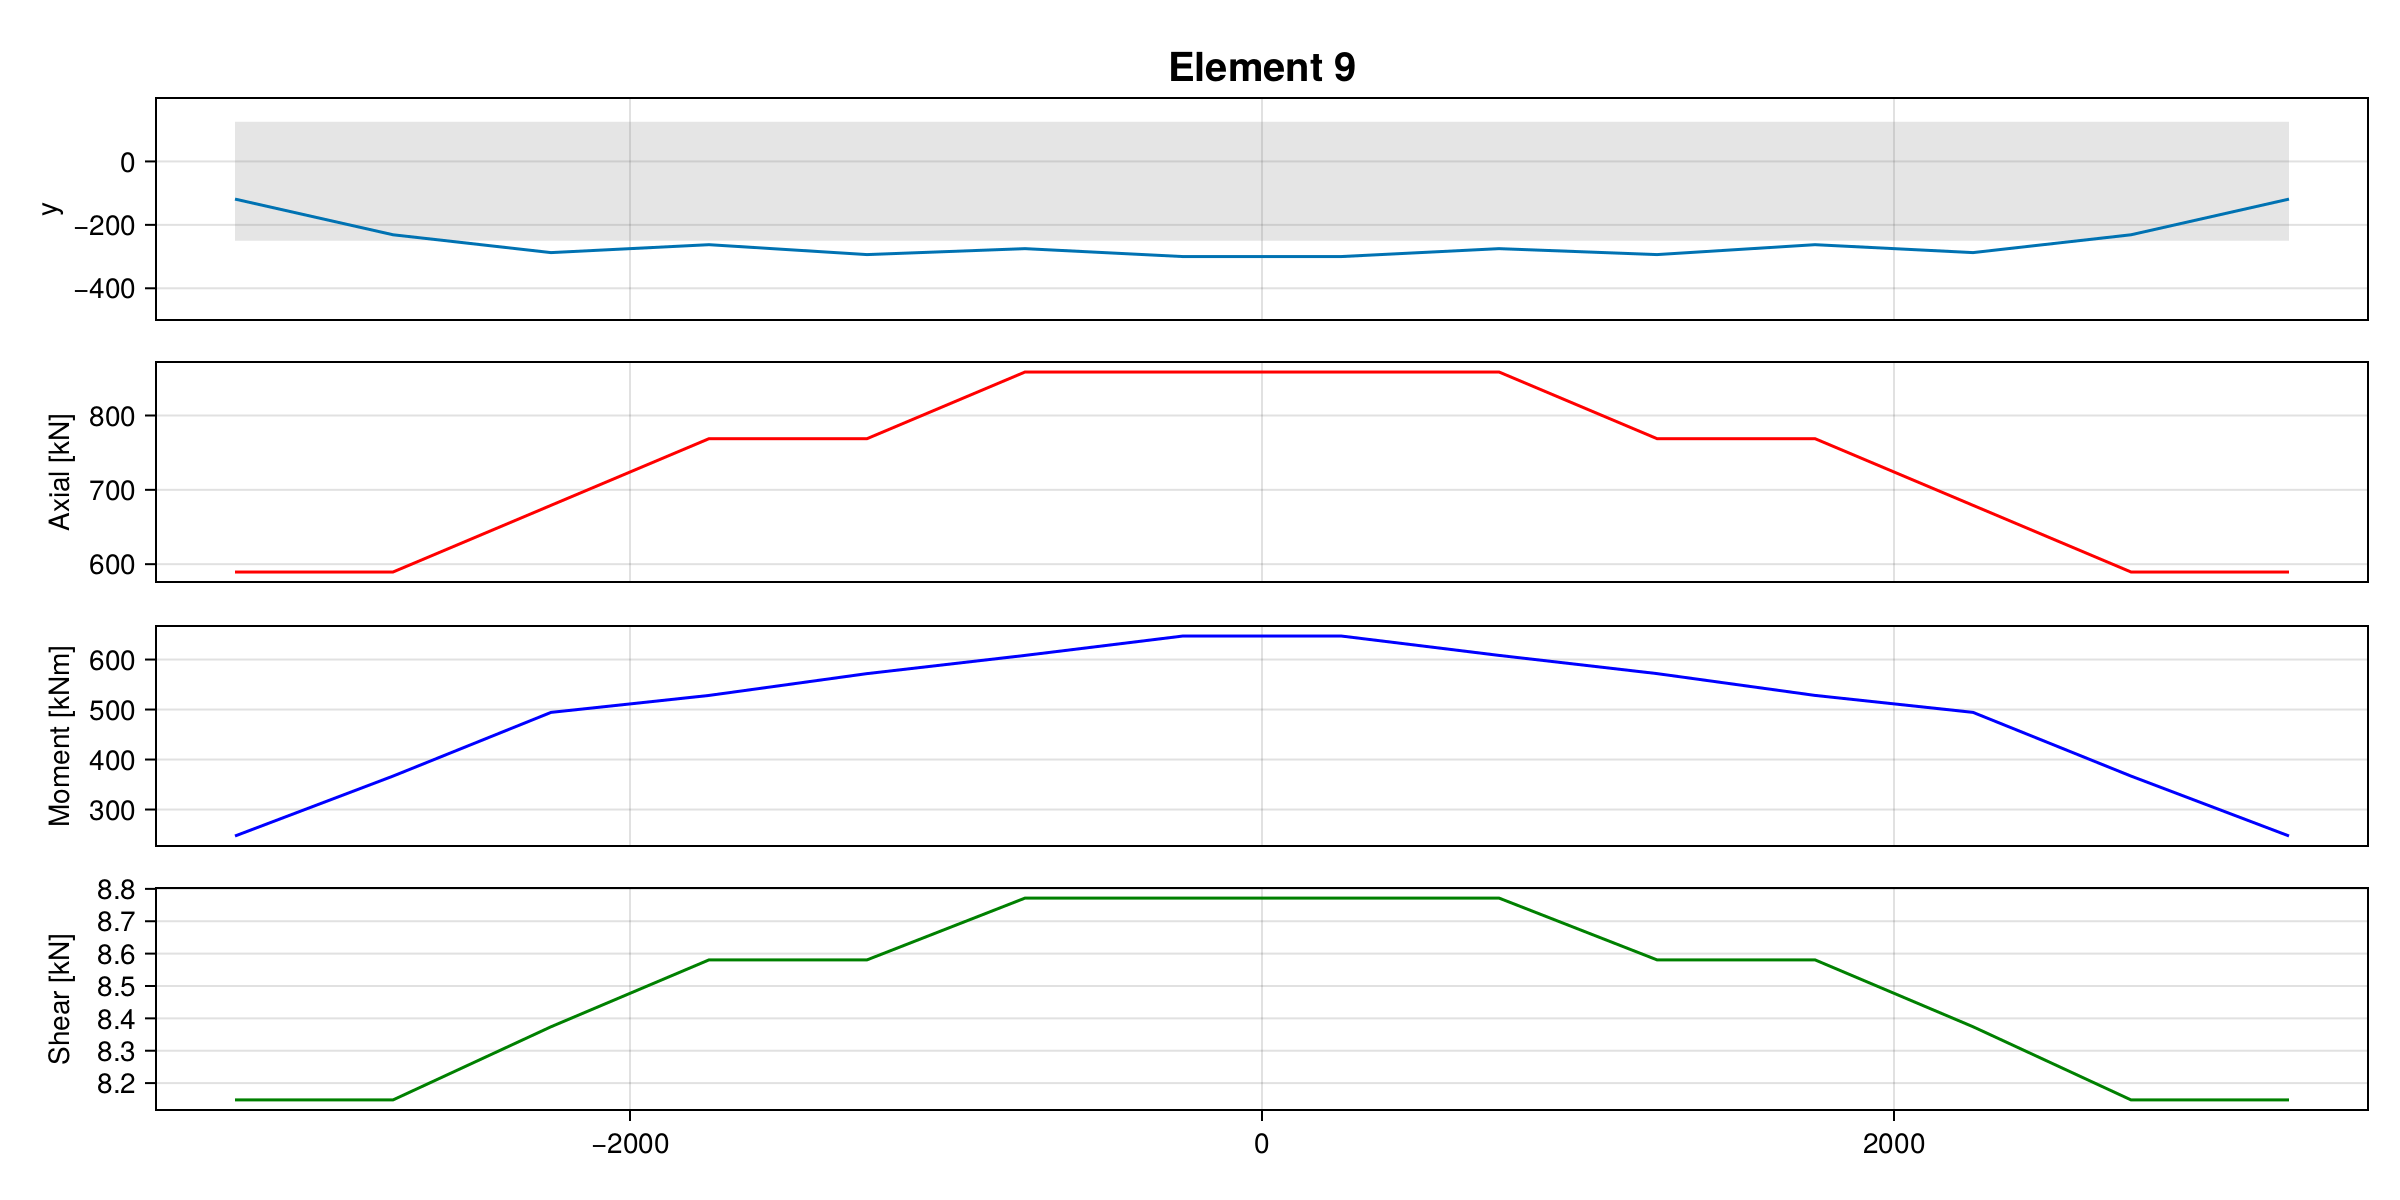

In [220]:
plot_element(9, designs)

In [221]:
demands

Row,vu,s_idx,pu,e_idx,type,ec_max,mu,idx,total_results
,Float64,Int64,Float64,Int64,String,Float64,Float64,Int64,Int64
1,129.755,1,-1.4779e-15,1,primary,0.0423597,129.755,1,21657
2,129.755,2,-7.38948e-16,1,primary,0.117666,194.632,2,20047
3,129.755,3,-7.38948e-16,1,primary,0.180421,259.509,3,17164
4,45.9809,4,1.4779e-15,1,primary,0.230625,283.246,4,15916
5,45.9809,5,7.38948e-16,1,primary,0.268278,306.237,5,14658
6,45.9809,6,-7.38948e-16,1,primary,0.29338,329.227,6,13408
7,45.9809,7,-7.38948e-16,1,primary,0.305931,352.218,7,12223
8,45.9809,8,0.0,1,primary,0.305931,352.218,8,12223
9,45.9809,9,0.0,1,primary,0.29338,329.227,9,13408
